In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# this is necessary to be able to import modules from the parent dir
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# uncomment this code to rerun the simulations
"""
from colag.colag import distance_simulation

distance = pd.DataFrame([x for _, x in zip(range(5000), distance_simulation())])
""";

In [3]:
#plt.scatter(sims.ham, sims.dist, alpha=1/5000);
sims = pd.read_csv('../data/hamming-jacard-cosine-comparison.txt', sep=' ', header=None, names=['g1', 'g2', 'ham', 'sent', 'trig'])
def plot_sims_attrs(sims, attr):
    stats = sims.groupby('ham')[attr]
    index = np.arange(len(stats))
    plt.errorbar(index, stats.mean(), stats.std(), label='mean')
    plt.plot(index, stats.max(), label='max')
    plt.plot(index, stats.min(), label='min')
    plt.grid()
    plt.legend()
    plt.yticks(np.arange(0, 1.1, 0.1));
    plt.xticks(index);
    len(sims)
#    plt.show()
#     sims.ham.hist(bins=13);
#     len(sims)
# plot_sims(sims)
plt.rcParams['figure.figsize'] = 10, 5
len(sims)

613713

# Hamming Distance vs Language Similarity

The graph below depicts a monte carlo simulation where at each datapoint we did the following:

1. pick a random grammar G1
2. pick a mutation rate 0-1
3. generate a grammar G2 by flipping the bits in G1 according to the mutation rate
4. compute the hamming distance between G1 and G2 (aka compute the number of bits that differ)
  - the hamming distance between 1100 and 1001 is 2.
5. compute the jacard difference between L(G1) and L(G2).
  - L(G1) is the language generated by G1, aka all the sentences that belong to G1 in the CoLaG db.
  - the jacard index is a set-similarity measure defined as $$1 - \frac{L(G1) \cap L(G2)}{L(G1) \cup L(G2)}$$

The result for 600k comparisons is plotted below

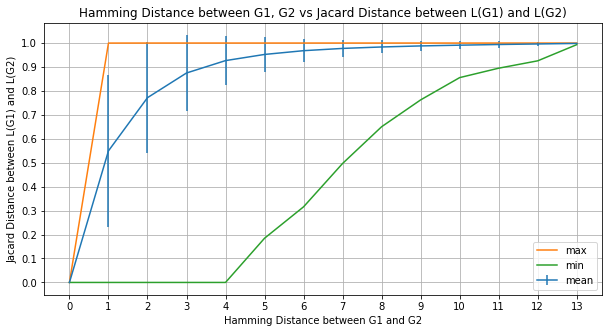

In [4]:
plot_sims_attrs(sims, 'sent')
plt.title('Hamming Distance between G1, G2 vs Jacard Distance between L(G1) and L(G2)')
plt.xlabel('Hamming Distance between G1 and G2')
plt.ylabel('Jacard Distance between L(G1) and L(G2)')
plt.show()

# Hamming Distance vs Cosine Distance

1. pick grammars G1 and G2 as described above
2. compute the hamming distance between G1 and G2
3. compute the Cosine Distance between T(G1) and T(G2)

## T(G)

T(G) is L(G) transformed into trigger-types.

A trigger-type (also called an irrelevance string) is an abstraction over an input sentence, which describes what sort of evidence the input serves as.

For example, the sentence in L(G)

    Aux S Not Verb

might be assigned a trigger-type in T(G) of

    ~1*~0~~011*0~
    
_(this is a made up example, that is not the actual trigger-type for that sentence)_

Let's consider only the first three characters (which correspond to the first three parameters).

We can read `~1*` this to mean that `Aux S Not Verb` is

- 1 $\to$ strong (?) evidence that P1 is set to `1`. We would not observe this sentence in a grammar where P1=0.
    
- ~ $\to$ irrelevant as evidence to P2. 
    Every grammar with P1=0 that can parse this sentence has a corresponding minimal pair grammar with P2=1 that can also parse this sentence. Thus knowing that L(G) generates this sentences gives us no information about P2 in G.
    
- `*` $\to$ ambiguous evidence of how P3 should be set. 
    This sentence exists in languages where P3=0 and in languages where P3=1.
    
T(G) can also be conceptualized as the distribution of trigger-types for each parameter.

Suppose that $$G = 010$$

And consider a notation

$$\underbrace{\frac{\text{17}}{\bf \text{1}}\ldots}_{P_7}$$ 

which means we observed 17 sentences that where strong evidence of $P_7 = 1$ in G.

We might expect to observe a $T(G)$ like

$$
T(G) = \underbrace{
                    \frac{70}{\bf \text{~}}
                    \frac{20} {\bf 0}
                    \frac{40}{\bf *}
                    \frac{0}{\bf 1}
       }_\text{P1}
       \space
       \underbrace{
                    \frac{90}{\bf \text{~}}
                    \frac{0} {\bf 0}
                    \frac{50}{\bf *}
                    \frac{30}{\bf 1}
       }_\text{P2}
       \space
       \underbrace{
                    \frac{60}{\bf \text{~}}
                    \frac{25} {\bf 0}
                    \frac{40}{\bf *}
                    \frac{0}{\bf 1}
       }_\text{P2}
$$

Converting these counts into a single vector

$$T(G) = \begin{bmatrix}
    70 & 20 & 40 & 0 & 90 & 0 & 50 & 30 & 60 & 25 & 40 & 0
\end{bmatrix}$$

we can then compute the cosine distance between the vectors.

Note that if we normalize the counts by number of sentences what we're left with feels like a fuzzy set.

613713

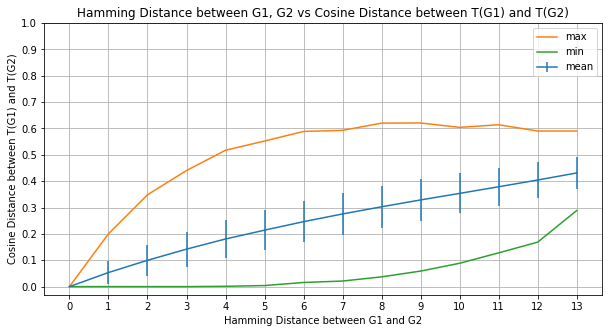

In [5]:
plot_sims_attrs(sims, 'trig')
plt.title('Hamming Distance between G1, G2 vs Cosine Distance between T(G1) and T(G2)')
plt.xlabel('Hamming Distance between G1 and G2')
plt.ylabel('Cosine Distance between T(G1) and T(G2)');
len(sims)

In [9]:
from itertools import repeat

irrel_vectors = pd.read_csv('../data/grammar-trigger-vectors.txt', header=None)

headers = ['P{}={}'.format(n, c)
 for irrstr, n in zip(repeat('~0*1'), range(1, 14))
 for c in irrstr]
headers.insert(0, 'grammar')
irrel_vectors.columns = headers

def compute_sums(row):
    row = row[1:]
    return sum(row) / 13

x = (
    irrel_vectors
    .div(irrel_vectors.apply(compute_sums, axis=1), axis=0)
    .assign(grammar=irrel_vectors.grammar)
)
x[x.grammar.isin([611, 584, 2253])]

,grammar,P1=~,P1=0,P1=*,P1=1,P2=~,P2=0,P2=*,P2=1,P3=~,...,P11=*,P11=1,P12=~,P12=0,P12=*,P12=1,P13=~,P13=0,P13=*,P13=1
77,2253,0.640212,0.000000,0.359788,0.0,0.515873,0.462081,0.022046,0.000000,0.034392,...,0.025573,0.0,0.108466,0.000000,0.012346,0.879189,0.228395,0.753086,0.018519,0.0
1096,584,0.619048,0.380952,0.000000,0.0,0.523810,0.304233,0.171958,0.000000,0.047619,...,0.384921,0.0,0.014550,0.951058,0.034392,0.000000,0.142857,0.472222,0.384921,0.0
1101,611,0.733333,0.000000,0.266667,0.0,0.733333,0.000000,0.144444,0.122222,0.066667,...,0.370370,0.0,0.020370,0.946296,0.033333,0.000000,0.133333,0.418519,0.448148,0.0


# Production System

Let's say we're running a language change simulation. We go from Grammar to Language to 

$ G \to L(G) \to Learners \to G_1, G_2, \ldots G_n \to ? $

First of all, an output $G_i$ from a Learner is not going to be a "crisp" grammar $010$ , but a 
"fuzzy" grammar $\begin{bmatrix} 0.01 & 0.998 & 0.003 \end{bmatrix}$

How do we decide what a speaker with this fuzzy grammar says?

I have a vague idea that involves the following 

- find the crisp grammars most similar to this fuzzy grammar $F$
- compute a distance measure $D(F, g)$ for each crisp grammar $G$
- sample the sentences from each $L(G)$, proportional to the $D_g$ for that $G$.

So the production system $P$ is something like

$$
P(F) = \sum_i{L(G_i) * D(F, G_i)}
$$

where summation here means concatenation.

## The distance function

Let's take the grammar above as a starting point.

$$
T(G) = \underbrace{
                    \frac{10}{\bf \text{~}}
                    \frac{20} {\bf 0}
                    \frac{40}{\bf *}
                    \frac{0}{\bf 1}
       }_\text{P1}
       \space
       \underbrace{
                    \frac{90}{\bf \text{~}}
                    \frac{0} {\bf 0}
                    \frac{50}{\bf *}
                    \frac{30}{\bf 1}
       }_\text{P2}
       \space
       \underbrace{
                    \frac{60}{\bf \text{~}}
                    \frac{25} {\bf 0}
                    \frac{40}{\bf *}
                    \frac{0}{\bf 1}
       }_\text{P2}
$$

We want to compare it with the fuzzy grammar

$$
F = \begin{bmatrix} 0.01 & 0.998 & 0.003 \end{bmatrix}
$$

we could start by normalizing T(G) by the number of sentences.

$$
T(G) = \underbrace{
                    \frac{0.14}{\bf \text{~}}
                    \frac{0.28} {\bf 0}
                    \frac{0.57}{\bf *}
                    \frac{0}{\bf 1}
       }_\text{P1}
       \space
       \underbrace{
                    \frac{0.53}{\bf \text{~}}
                    \frac{0} {\bf 0}
                    \frac{0.30}{\bf *}
                    \frac{0.18}{\bf 1}
       }_\text{P2}
       \space
       \underbrace{
                    \frac{0.48}{\bf \text{~}}
                    \frac{0.2} {\bf 0}
                    \frac{0.32}{\bf *}
                    \frac{0}{\bf 1}
       }_\text{P2}
$$

And then subtracting the vectors from each other, discarding the * and ~ information.

$$D(F, T(G)) = \begin{bmatrix} |0.28 - 0.01| & |0.998 - 1 - 0.18| & |0.003 - 0.2| \end{bmatrix}$$

$$D(F, T(G)) = \begin{bmatrix} 0.27 & 0.18 & 0.12 \end{bmatrix}$$

we should be making use of the * and ~ data somehow. If a $P_i$ is irrelevant to $G$ we probably shouldn't penalize based on that value.